# Modeling 30-Day Readmissions for Diabetics

## Overview
Medicare, Medicade and many private payers either reduce payments, or do not pay, for patient readmissions within 30 days of a discharge.  It would be very useful to be able to predict which of these patients was likely to be readmitted within 30 days.  In this example, DataRobot will try to model whether a patient will be readmitted, based on information available at the time of discharge.

## Prerequisites
In order to run this notebook yourself, you will need the following:

- This notebook. If you are viewing this in the HTML documentation bundle, you can download all of the example notebooks and supporting materials from [Downloads](../index.rst).
- The datasets required for this notebook. These are in the same directory as this notebook.
- A DataRobot API token. You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile`.

## Set Up
This example assumes that the DataRobot Python client package has been installed and configured with the credentials of a DataRobot user with API access permissions.

## Data Sources
Data is from a study of diabetic patients who were admitted to hospital and is available at https://www.hindawi.com/journals/bmri/2014/781670/sup/.  To narrow down the amount of data involved, the dataset assembled is a 20,000 row random sample of the original data.  A patientient was flagged as readmitted if they returned to the hospital and were addmitted within 30 days of the previous discharge.

## Dataset Structure
Each row in the assembled dataset contains the following columns

    - Encounter ID
        - Numeric
        - Unique identifier of an encounter
    - Patient number
        - Numeric
        - Unique identifier of a patient
    - Race
        - Nominal
        - Values: Caucasian, Asian, African American, Hispanic, and other
    - Gender
        - Nominal
        - Values: male, female and unknown
    - Age
        - Nominal
        - Grouped in 10-year intervals: [0, 10), [10, 20), ..., [90, 100)
    - Weight
        - Nominal
        - Weight in pounds.
    - Admission type
        - Nominal
        - Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn,
          and not available
    - Discharge disposition
        - Nominal
        - Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not
          available
    - Admission source
        - Nominal
        - Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room,
          and transfer from a hospital
    - Time in hospital
        - Numeric
        - Integer number of days between admission and discharge
    - Payer code
        - Nominal
        - Integer identifier corresponding to 23 distinct values, for example, Blue Cross Blue Shield, Medicare,
          and self-pay
    - Medical specialty
        - Nominal
        - Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for
          example, cardiology, internal medicine, familygeneral practice, and surgeon
    - Number of lab procedures
        - Numeric
        - Number of lab tests performed during the encounter
    - Number of procedures
        - Numeric
        - Number of procedures (other than lab tests) performed during the encounter
    - Number of medications
        - Numeric
        - Number of distinct generic names administered during the encounter
    - Number of outpatient visits
        - Numeric
        - Number of outpatient visits of the patient in the year preceding the encounter
    - Number of emergency visits
        - Numeric
        - Number of emergency visits of the patient in the year preceding the encounter
    - Number of inpatient visits
        - Numeric
        - Number of inpatient visits of the patient in the year preceding the encounter
    - Diagnosis 1
        - Nominal
        - The primary diagnosis (coded as first three digits of ICD9); 848 distinct values
    - Diagnosis 2
        - Nominal
        - Secondary diagnosis (coded as first three digits of ICD9); 923 distinct values
    - Diagnosis 3
        - Nominal
        - Additional secondary diagnosis (coded as first three digits of ICD9); 954 distinct values
    - Number of diagnoses
        - Numeric
        - Number of diagnoses entered to the system
    - Glucose serum test result
        - Nominal
        - Indicates the range of the result or if the test was not taken. Values: “>200”, “>300”, “normal” and
          “none” if not measured
    - A1c test result
        - Nominal
        - Indicates the range of the result or if the test was not taken. Values: “>8” if the result was greater
          than 8%, “>7” if the result was greater than 7% but less than 8%, “normal” if the result was less than
          7%, and “none” if not measured.
    - Change of medications
        - Nominal
        - Indicates if there was a change in diabetic medications (either dosage or generic name). 
          Values: “change” and “no change”
    - Diabetes medications
        - Nominal
        - Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”
    - 24 features for medications
        - Nominal
        - For the generic names: metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide,
          glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone,
          tolazamide, examide, sitagliptin, insulin, glyburide-metformin, glipizide-metformin, 
          glimepiride-pioglitazone, metformin-rosiglitazone, and metformin-pioglitazone, the feature indicates
          whether the drug was prescribed or there was a change in the dosage. Values: “up” if the dosage was
          increased during the encounter, “down” if the dosage was decreased, “steady” if the dosage did not
          change, and “no” if the drug was not prescribed
    - Readmitted
        - Boolean
        - Days to inpatient readmission. Values: “30” if the patient was readmitted in more than 30 days, and
          “No” for no record of readmission.,
    - admit_description
        - Nominal
        - Admition source description.
    - admit_type_description
        - Nominal
        - Admition type description.
    - discharge_description
        - Nominal
        - discharge disposition description.
    - diag_1_desc
        - Nominal
        - diagnosis code 1 description.
    - diag_2_desc
        - Nominal
        - diagnosis code 2 description.
    - diag_3_desc
        - Nominal
        - diagnosis code 3 description.![image.png](attachment:image.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import pandas as pd
import datarobot as dr

from functools import reduce

In [3]:
data_path = "/Users/julius.king/Sample Data/781670.f1/Readmission_Sample.csv"
Readmission = pd.read_csv(data_path, encoding ='latin')
Readmission.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,metformin-pioglitazone,change,diabetesMed,readmitted,admit_description,admit_type_description,discharge_description,diag_1_desc,diag_2_desc,diag_3_desc
0,AfricanAmerican,Female,[40-50),?,1,6,7,11,DM,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged/transferred to home with home healt...,"Pressure ulcer, unspecified site",Cellulitis and abscess of face,"Pressure ulcer, unspecified site"
1,Caucasian,Male,[80-90),?,2,1,7,4,BC,Emergency/Trauma,...,No,No,No,True,Emergency Room,Urgent,Discharged to home,Pleurisy without mention of effusion or curren...,"Congestive heart failure, unspecified",Paroxysmal supraventricular tachycardia
2,AfricanAmerican,Female,[60-70),?,1,1,7,2,CM,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,"Postoperative shock, unspecified","Urinary tract infection, site not specified",Cardiac catheterization as the cause of abnorm...
3,Caucasian,Female,[40-50),?,1,1,7,1,?,?,...,No,No,No,False,Emergency Room,Emergency,Discharged to home,"Postoperative shock, unspecified",Home accidents,"Extrinsic asthma, unspecified"
4,Caucasian,Female,[80-90),?,1,1,7,7,MC,?,...,No,Ch,Yes,False,Emergency Room,Emergency,Discharged to home,Simple chronic bronchitis,"Pneumonia, organism unspecified",Diabetes mellitus without mention of complicat...


Based on the description of Discharge disposition, we would want to exclude "Expired" individuals from our analysis, so let's take a look at that field and it's corresponding description field:

In [4]:
discharges = Readmission.groupby(['discharge_description', 'discharge_disposition_id'])
for p in discharges.groups:
    print(p, "has ", len(discharges.groups[p]), " entries")

('Discharged/transferred to home with home health service', 6) has  2686  entries
('Discharged to home', 1) has  12375  entries
(nan, 18) has  766  entries
('Expired', 11) has  333  entries
('Discharged/transferred to SNF', 3) has  2928  entries
('Discharged/transferred to another short term hospital', 2) has  419  entries
('Not Mapped', 25) has  186  entries
('Discharged/transferred to another type of inpatient care institution', 5) has  238  entries
('Discharged/transferred to another rehab fac including rehab units of a hospital .', 22) has  412  entries
('Hospice / medical facility', 14) has  91  entries
('Discharged/transferred to ICF', 4) has  156  entries
('Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital', 28) has  28  entries
('Left AMA', 7) has  140  entries
('Discharged/transferred to a long term care hospital.', 23) has  97  entries
('Hospice / home', 13) has  76  entries
('Discharged/transferred within this instituti

In [4]:
logan_2013_modeling = prepare_modeling_dataset(logan_2013)
logan_2013_modeling.head()

,was_delayed,daily_rainfall,did_rain,Carrier Code,Flight Number,Tail Number,Destination Airport,Scheduled Departure Time,day_of_week,month
0,False,0.0,False,US,225,N662AW,PHX,16:20,Fri,2
1,False,0.0,False,US,280,N822AW,PHX,06:00,Fri,2
2,False,0.0,False,US,303,N653AW,CLT,09:35,Fri,2
3,True,0.0,False,US,604,N640AW,PHX,09:55,Fri,2
4,False,0.0,False,US,722,N715UW,PHL,18:30,Fri,2


For the workshop, we'll sample down to a very small dataset to keep things moving.

In [5]:
# logan_2013_modeling = logan_2013_modeling.loc[0:1000, :]

## DataRobot Modeling
As part of this use case, in `model_flight_ontime.py`, a DataRobot project will be created and used to run a variety of models against the assembled datasets.  By default, DataRobot will run autopilot on the automatically generated Informative Features list, which excludes certain pathological features (like Carrier Code in this example, which is always the same value), and we will also create a custom feature list excluding the amount of rainfall on the day of the flight.

This notebook shows how to use the Python API client to create a project, create feature lists, train models with different sample percents and feature lists, and view the models that have been run. It will:

  - create a project
  - create a new feature list (no foreknowledge) excluding the rainfall features
  - set the target to `was_delayed`, and run DataRobot autopilot on the Informative Features list
  - rerun autopilot on a new feature list
  - make predictions on a new data set

## Configure the Python Client
Configuring the client requires the following two things:

- A DataRobot endpoint - where the API server can be found
- A DataRobot API token - a token the server uses to identify and validate the user making API requests

The endpoint is usually the URL you would use to log into the DataRobot Web User Interface (e.g., https://app.datarobot.com) with "/api/v2/" appended, e.g., (https://app.datarobot.com/api/v2/).

You can find your API token by logging into the DataRobot Web User Interface and looking in your `Profile.`

The Python client can be configured in several ways. The example we'll use in this notebook is to point to a `yaml` file that has the information. This is a text file containing two lines like this:
```yaml
endpoint: https://app.datarobot.com/api/v2/
token: not-my-real-token
```

If you want to run this notebook without changes, please save your configuration in a file located under your home directory called `~/.config/datarobot/drconfig.yaml`.

In [6]:
# Initialization with arguments
dr.Client(token='', endpoint='https://app.datarobot.com/api/v2/')

## Starting a Project

In [7]:
project = dr.Project.start(logan_2013_modeling,
                           project_name='Airline Delays - was_delayed',
                           target="was_delayed")
print('Project ID: {}'.format(project.id))

Project ID: 5cf09ef05a33231214cf460c


## Jobs and the Project Queue

You can view the project in your browser:

In [8]:
#  If running notebook remotely
project.open_leaderboard_browser()

False

In [9]:
#  Set worker count higher.
#  Passing -1 sets it to the maximum available to your account.
project.set_worker_count(-1)

Project(Airline Delays - was_delayed)

In [10]:
project.pause_autopilot()

True

In [11]:
#  More jobs will go in the queue in each stage of autopilot.
#  This gets the currently inprogress and queued jobs
project.get_model_jobs()

[ModelJob(Logistic Regression, status=inprogress),
 ModelJob(Regularized Logistic Regression (L2), status=inprogress),
 ModelJob(Auto-tuned K-Nearest Neighbors Classifier (Euclidean Distance), status=inprogress),
 ModelJob(Majority Class Classifier, status=inprogress),
 ModelJob(Gradient Boosted Trees Classifier, status=inprogress),
 ModelJob(Breiman and Cutler Random Forest Classifier, status=inprogress),
 ModelJob(RuleFit Classifier, status=inprogress),
 ModelJob(Regularized Logistic Regression (L2), status=inprogress),
 ModelJob(TensorFlow Neural Network Classifier, status=inprogress),
 ModelJob(eXtreme Gradient Boosted Trees Classifier with Early Stopping, status=inprogress),
 ModelJob(Elastic-Net Classifier (L2 / Binomial Deviance), status=inprogress),
 ModelJob(Nystroem Kernel SVM Classifier, status=queue),
 ModelJob(RandomForest Classifier (Gini), status=queue),
 ModelJob(Vowpal Wabbit Classifier, status=queue),
 ModelJob(Generalized Additive2 Model, status=queue),
 ModelJob(Lig

In [12]:
project.unpause_autopilot()

True

## Features

In [13]:
features = project.get_features()
features

[Feature(did_rain),
 Feature(Destination Airport),
 Feature(Carrier Code),
 Feature(Flight Number),
 Feature(Tail Number),
 Feature(day_of_week),
 Feature(month),
 Feature(Scheduled Departure Time),
 Feature(daily_rainfall),
 Feature(was_delayed),
 Feature(Scheduled Departure Time (Hour of Day))]

In [14]:
pd.DataFrame([f.__dict__ for f in features])

,date_format,feature_type,id,importance,low_information,max,mean,median,min,na_count,name,project_id,std_dev,target_leakage,time_series_eligibility_reason,time_series_eligible,time_step,time_unit,unique_count
0,None,Boolean,2,0.029045,False,1,0.36,0,0,0,did_rain,5cf09ef05a33231214cf460c,0.48,FALSE,notADate,False,None,None,2
1,None,Categorical,6,0.003714,True,None,None,None,None,0,Destination Airport,5cf09ef05a33231214cf460c,None,FALSE,notADate,False,None,None,5
2,None,Categorical,3,NaN,True,None,None,None,None,0,Carrier Code,5cf09ef05a33231214cf460c,None,SKIPPED_DETECTION,notADate,False,None,None,1
3,None,Numeric,4,0.005900,False,2165,1705.63,2021,67,0,Flight Number,5cf09ef05a33231214cf460c,566.67,FALSE,notADate,False,None,None,329
4,None,Categorical,5,-0.004512,True,None,None,None,None,398,Tail Number,5cf09ef05a33231214cf460c,None,FALSE,notADate,False,None,None,296
5,None,Categorical,8,0.003452,True,None,None,None,None,0,day_of_week,5cf09ef05a33231214cf460c,None,FALSE,notADate,False,None,None,7
6,None,Numeric,9,0.003043,True,12,6.47,6,1,0,month,5cf09ef05a33231214cf460c,3.38,FALSE,notADate,False,None,None,12
7,%H:%M,Time,7,0.058245,False,21:30,12:26,12:00,05:00,0,Scheduled Departure Time,5cf09ef05a33231214cf460c,0.19 days,FALSE,notADate,False,None,None,77
8,None,Numeric,1,0.034295,False,3.07,0.12,0,0,0,daily_rainfall,5cf09ef05a33231214cf460c,0.33,FALSE,notADate,False,None,None,58
9,None,Boolean,0,1.000000,False,1,0.098,0,0,0,was_delayed,5cf09ef05a33231214cf460c,0.3,SKIPPED_DETECTION,notADate,False,None,None,2


Three feature lists are automatically created:

- _Raw Features_: one for all features
- _Informative Features_: one based on features with any information (columns with no variation are excluded)
- _Univariate Importance_: one based on univariate importance (this is only created after the target is set)

_Informative Features_ is the one used by default in autopilot.

In [15]:
feature_lists = project.get_featurelists()
feature_lists

[Featurelist(Raw Features),
 Featurelist(Informative Features),
 Featurelist(Univariate Selections)]

In [16]:
# create a featurelist without the rain features
# (since they leak future information)
informative_feats = [lst for lst in feature_lists if
                     lst.name == 'Informative Features'][0]
no_foreknowledge_features = list(
    set(informative_feats.features) - {'daily_rainfall', 'did_rain'})

In [17]:
no_foreknowledge = project.create_featurelist('no foreknowledge',
                                              no_foreknowledge_features)
no_foreknowledge

Featurelist(no foreknowledge)

In [23]:
project.get_status()

{'autopilot_done': True,
 'stage_description': 'Ready for modeling',
 'stage': 'modeling'}

In [19]:
# This waits until autopilot is complete:
project.wait_for_autopilot(check_interval=90)

In progress: 16, queued: 18 (waited: 0s)
In progress: 17, queued: 17 (waited: 1s)
In progress: 17, queued: 17 (waited: 1s)
In progress: 17, queued: 17 (waited: 2s)
In progress: 18, queued: 16 (waited: 4s)
In progress: 19, queued: 14 (waited: 6s)
In progress: 20, queued: 13 (waited: 10s)
In progress: 20, queued: 13 (waited: 17s)
In progress: 20, queued: 7 (waited: 30s)
In progress: 9, queued: 0 (waited: 56s)
In progress: 16, queued: 0 (waited: 107s)
In progress: 1, queued: 0 (waited: 199s)
In progress: 1, queued: 0 (waited: 289s)
In progress: 1, queued: 0 (waited: 379s)
In progress: 1, queued: 0 (waited: 470s)
In progress: 4, queued: 0 (waited: 560s)
In progress: 0, queued: 0 (waited: 652s)


In [20]:
project.start_autopilot(no_foreknowledge.id)

In [22]:
project.wait_for_autopilot(check_interval=90)

In progress: 0, queued: 0 (waited: 0s)


## Models

In [24]:
models = project.get_models()
example_model = models[0]
example_model

Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features')

Models represent fitted models and have various data about the model, including metrics:

In [25]:
example_model.metrics

{'AUC': {'backtesting': None,
  'holdout': 0.76509,
  'backtestingScores': None,
  'crossValidation': 0.755494,
  'validation': 0.75702},
 'Rate@Top5%': {'backtesting': None,
  'holdout': 0.45902,
  'backtestingScores': None,
  'crossValidation': 0.489794,
  'validation': 0.5034},
 'RMSE': {'backtesting': None,
  'holdout': 0.27627,
  'backtestingScores': None,
  'crossValidation': 0.27529400000000004,
  'validation': 0.27448},
 'Kolmogorov-Smirnov': {'backtesting': None,
  'holdout': 0.42279,
  'backtestingScores': None,
  'crossValidation': 0.398738,
  'validation': 0.40472},
 'Rate@TopTenth%': {'backtesting': None,
  'holdout': 0.75,
  'backtestingScores': None,
  'crossValidation': 0.8000019999999999,
  'validation': 0.66667},
 'LogLoss': {'backtesting': None,
  'holdout': 0.27178,
  'backtestingScores': None,
  'crossValidation': 0.272296,
  'validation': 0.27079},
 'FVE Binomial': {'backtesting': None,
  'holdout': 0.14992,
  'backtestingScores': None,
  'crossValidation': 0.1485

In [26]:
def sorted_by_log_loss(models, test_set):
    models_with_score = [model for model in models if
                         model.metrics['LogLoss'][test_set] is not None]
    return sorted(models_with_score,
                  key=lambda model: model.metrics['LogLoss'][test_set])

Let's choose the models (from each feature set, to compare the scores) with the best LogLoss score from those with the rain and those without:

In [27]:
models = project.get_models()
fair_models = [mod for mod in models if
               mod.featurelist_id == no_foreknowledge.id]
rain_cheat_models = [mod for mod in models if
                     mod.featurelist_id == informative_feats.id]

In [29]:
best_fair_model = sorted_by_log_loss(fair_models, 'crossValidation')[0]
best_cheat_model = sorted_by_log_loss(rain_cheat_models, 'crossValidation')[0]
best_fair_model.metrics, best_cheat_model.metrics

({'AUC': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.7159880000000001,
   'validation': 0.71975},
  'Rate@Top5%': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.38231200000000004,
   'validation': 0.40136},
  'RMSE': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.285686,
   'validation': 0.28605},
  'Kolmogorov-Smirnov': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.32483799999999996,
   'validation': 0.31392},
  'Rate@TopTenth%': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.533332,
   'validation': 1.0},
  'LogLoss': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'crossValidation': 0.290366,
   'validation': 0.2901},
  'FVE Binomial': {'backtesting': None,
   'holdout': None,
   'backtestingScores': None,
   'c

Top models all blenders, use LGBM for speed

In [32]:
best_fair_model = sorted_by_log_loss(fair_models, 'crossValidation')[4]
best_fair_model.model_type

'Light Gradient Boosting on ElasticNet Predictions '

## Visualizing Models

Example from:
https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.16.0/examples/advanced_model_insights/Advanced_Model_Insights.html

In [33]:
feature_impacts = best_fair_model.get_or_request_feature_impact()

In [34]:
dr_dark_blue = '#08233F'
dr_blue = '#1F77B4'
dr_orange = '#FF7F0E'
dr_red = '#BE3C28'

Text(0.5, 1.04, 'Feature Impact')

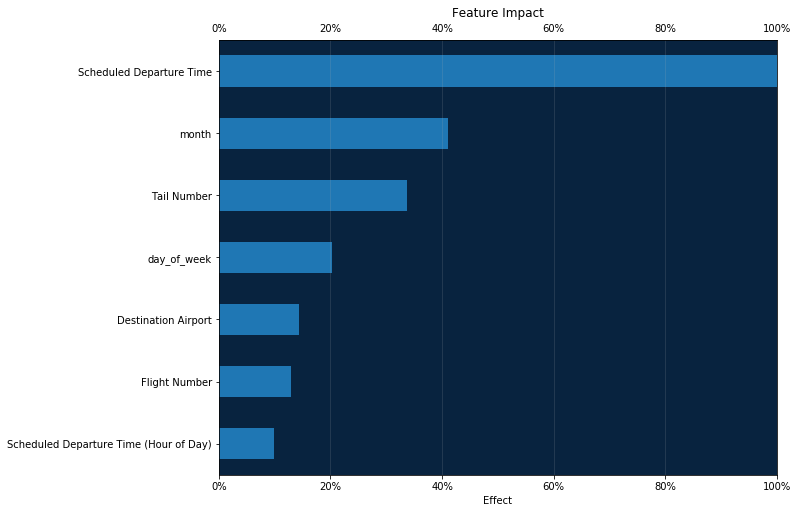

In [43]:
# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df = pd.DataFrame(feature_impacts)
impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 8))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

## Average many model impacts

In [38]:
def get_impact_as_df(model):
    impact_df = pd.DataFrame(model.get_or_request_feature_impact())
    impact_df['model_name'] = model.model_type
    return(impact_df)

In [39]:
n = 5
top_n_models = sorted_by_log_loss(fair_models, 'crossValidation')[4:n+4]
top_impacts = [get_impact_as_df(model) for model in top_n_models]
impact_df = pd.concat(top_impacts)

In [41]:
impact_df = impact_df.groupby('featureName', as_index=False)['impactNormalized'].mean()

Text(0.5, 1.04, 'Feature Impact')

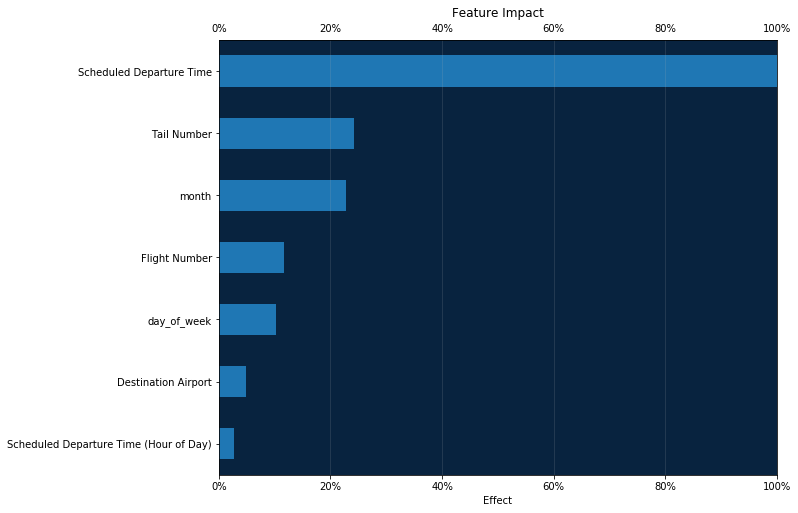

In [42]:
# Formats the ticks from a float into a percent
percent_tick_fmt = mtick.PercentFormatter(xmax=1.0)

impact_df.sort_values(by='impactNormalized', ascending=True, inplace=True)

# Positive values are blue, negative are red
bar_colors = impact_df.impactNormalized.apply(lambda x: dr_red if x < 0
                                              else dr_blue)

ax = impact_df.plot.barh(x='featureName', y='impactNormalized',
                         legend=False,
                         color=bar_colors,
                         figsize=(10, 8))
ax.xaxis.set_major_formatter(percent_tick_fmt)
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.grid(True, alpha=0.2)
ax.set_facecolor(dr_dark_blue)

plt.ylabel('')
plt.xlabel('Effect')
plt.xlim((None, 1))  # Allow for negative impact
plt.title('Feature Impact', y=1.04)

## Unlocking the Holdout

To maintain holdout scores as a valid estimate of out-of-sample error, we recommend not looking at them until late in the project. For this reason, holdout scores are locked until you unlock them.

In [44]:
project.unlock_holdout()

Project(Airline Delays - was_delayed)

In [45]:
best_fair_model = dr.Model.get(project.id, best_fair_model.id)
best_cheat_model = dr.Model.get(project.id, best_cheat_model.id)

In [46]:
best_fair_model.metrics['LogLoss'], best_cheat_model.metrics['LogLoss']

({'backtesting': None,
  'holdout': 0.29408,
  'backtestingScores': None,
  'crossValidation': 0.291076,
  'validation': 0.29006},
 {'backtesting': None,
  'holdout': 0.27193,
  'backtestingScores': None,
  'crossValidation': 0.270848,
  'validation': 0.27156})

## Retrain on 100%

When ready to use the final model, you will probably get the best performance by retraining on 100% of the data.

In [47]:
model_job_fair_100pct_id = best_fair_model.train(sample_pct=100)
model_job_fair_100pct_id

'235'

Wait for the model to complete:

In [48]:
model_fair_100pct = dr.models.modeljob.wait_for_async_model_creation(
    project.id, model_job_fair_100pct_id)
model_fair_100pct.id

'5cf1331d5a332321dbcf49be'

## Predictions

Let's make predictions for some new data. This new data will need to have the same transformations applied as we applied to the training data.

In [49]:
logan_2014 = pd.read_csv("../data/logan-US-2014.csv")
logan_2014_modeling = prepare_modeling_dataset(logan_2014)
logan_2014_modeling.head()

,was_delayed,daily_rainfall,did_rain,Carrier Code,Flight Number,Tail Number,Destination Airport,Scheduled Departure Time,day_of_week,month
0,False,0.0,False,US,450,N809AW,PHX,10:00,Sat,2
1,False,0.0,False,US,553,N814AW,PHL,07:00,Sat,2
2,False,0.0,False,US,582,N820AW,PHX,06:10,Sat,2
3,False,0.0,False,US,601,N678AW,PHX,16:20,Sat,2
4,False,0.0,False,US,657,N662AW,CLT,09:45,Sat,2


In [50]:
prediction_dataset = project.upload_dataset(logan_2014_modeling)
predict_job = model_fair_100pct.request_predictions(prediction_dataset.id)
prediction_dataset.id

'5cf133d35a332322afcf4602'

In [51]:
predictions = predict_job.get_result_when_complete()

In [52]:
pd.concat([logan_2014_modeling, predictions], axis=1).head()

,was_delayed,daily_rainfall,did_rain,Carrier Code,Flight Number,Tail Number,Destination Airport,Scheduled Departure Time,day_of_week,month,positive_probability,prediction,prediction_threshold,row_id,class_0.0,class_1.0
0,False,0.0,False,US,450,N809AW,PHX,10:00,Sat,2,0.055054,0.0,0.5,0,0.944946,0.055054
1,False,0.0,False,US,553,N814AW,PHL,07:00,Sat,2,0.045004,0.0,0.5,1,0.954996,0.045004
2,False,0.0,False,US,582,N820AW,PHX,06:10,Sat,2,0.030196,0.0,0.5,2,0.969804,0.030196
3,False,0.0,False,US,601,N678AW,PHX,16:20,Sat,2,0.201461,0.0,0.5,3,0.798539,0.201461
4,False,0.0,False,US,657,N662AW,CLT,09:45,Sat,2,0.072447,0.0,0.5,4,0.927553,0.072447


Let's have a look at our results. Since this is a binary classification problem, as the `positive_probability` approaches zero this row is a stronger candidate for the negative class (_the flight will leave on-time_), while  as it approaches one, the outcome is more likely to be of the positive class (_the flight will be delayed_). From the KDE (Kernel Density Estimate) plot below, we can see that this sample of the data is weighted stronger to the negative class.

In [53]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [54]:
matplotlib.rcParams['figure.figsize'] = (15, 10)  # make charts bigger

Text(0.5, 1.0, 'Prediction Distribution')

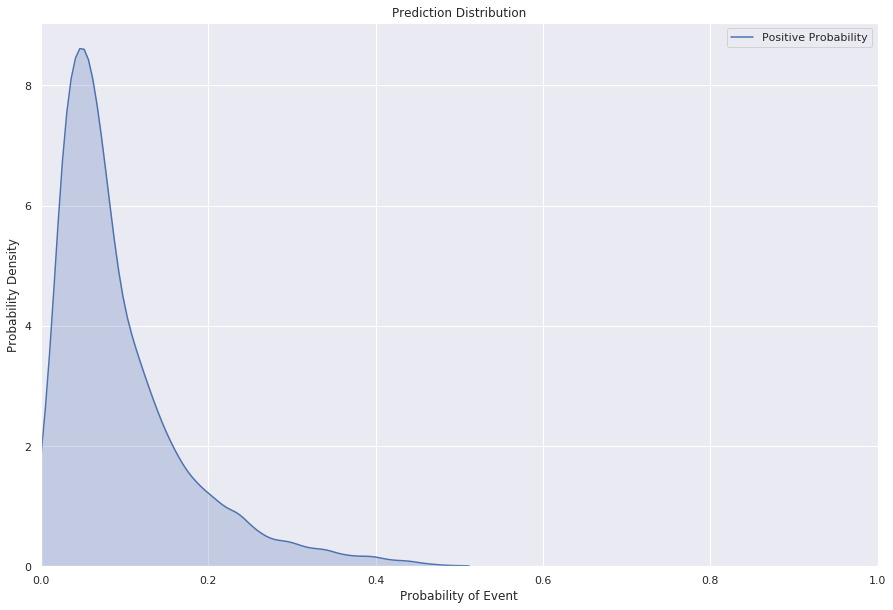

In [55]:
sns.set(color_codes=True)
sns.kdeplot(predictions.positive_probability, shade=True, cut=0,
            label='Positive Probability')
plt.xlim((0, 1))
plt.ylim((0, None))
plt.xlabel('Probability of Event')
plt.ylabel('Probability Density')
plt.title('Prediction Distribution')

## Model Refresh

In [56]:
existing_model = dr.Model.get(project.id,
                              best_fair_model.id)

In [57]:
new_project = dr.Project.start(logan_2013_modeling,
                               project_name='Airline Delays v2',
                               target="was_delayed",
                               autopilot_on=False)

In [58]:
# create a featurelist without the rain features
# (since they leak future information)
informative_feats = [lst for lst in feature_lists if
                     lst.name == 'Informative Features'][0]
no_foreknowledge_features = list(
    set(informative_feats.features) - {'daily_rainfall', 'did_rain'})

no_foreknowledge = new_project.create_featurelist('no foreknowledge',
                                              no_foreknowledge_features)
no_foreknowledge

Featurelist(no foreknowledge)

In [59]:
new_project.unlock_holdout()

Project(Airline Delays v2)

In [60]:
existing_model.blueprint_id

'dbb969166feb00b6d8e0cecf092678fd'

In [61]:
new_model_job = new_project.train(
    existing_model.blueprint_id,
    source_project_id=project.id,
    sample_pct=100,
    featurelist_id=no_foreknowledge.id)

new_model = dr.models.modeljob.wait_for_async_model_creation(new_project.id, new_model_job)

## Model Factory

In [62]:
logan_2013_modeling = prepare_modeling_dataset(logan_2013)

In [63]:
logan_2013_modeling.did_rain.sum()

6689

In [64]:
dataset_list = [logan_2013_modeling.loc[logan_2013_modeling.did_rain,:].sample(1000),
                logan_2013_modeling.loc[~logan_2013_modeling.did_rain,:].sample(1000)]
project_names = ['Delays With Rain', 'Delays Without Rain']

In [65]:
projects = list()
for i in range(2):
    projects.append(dr.Project.start(dataset_list[i],
                               project_name=project_names[i],
                               target="was_delayed",
                               autopilot_on=True))

## Advanced: Clustering on Prediction Explanations

In [66]:
# #####################################################################
# Generic method to do everything required to retrieve the scores and
# explanations for a given data set.
# #####################################################################
def retrieve_prediction_explanations(proj, mod, pdata, n_reasons = 5):
    # UPLOAD THE DATASET
    dataset = proj.upload_dataset(pdata) # Returns an instance of [PredictionDataset]
    pred_job = mod.request_predictions(dataset.id)
    preds = pred_job.get_result_when_complete()
    # NOW WE NEED TO ENSURE THAT FEATURE IMPACT EXISTS FOR THAT MODEL
    try:
        impact_job = mod.request_feature_impact()
        impact_job.wait_for_completion(300)
    except dr.errors.JobAlreadyRequested:
        pass  # already computed
    # NOW ENSURE THAT THE PREDICTION EXPLANATIONS ARE COMPUTED 
    try:
        dr.PredictionExplanationsInitialization.get(proj.id, mod.id)
    except dr.errors.ClientError as e:
        assert e.status_code == 404  # haven't been computed
        init_job = dr.PredictionExplanationsInitialization.create(proj.id, mod.id)
        init_job.wait_for_completion()
    # RUN THE REASON CODE JOB
    rc_job = dr.PredictionExplanations.create(proj.id,
                               mod.id,
                               dataset.id,
                               max_explanations=n_reasons,
                               threshold_low=None,
                               threshold_high=None)
    rc = rc_job.get_result_when_complete(max_wait=1200)
    all_rows = rc.get_all_as_dataframe()
    return all_rows

In [67]:
exp = retrieve_prediction_explanations(project, best_fair_model, 
                                       logan_2014_modeling,
                                       n_reasons = 6)

In [68]:
# ######################################################################
# UTILITY FUNCTIONS FOR CLEAN RE_USABLE BEHAVIOUR - thanks to John Hawkins for this piece
# ######################################################################
def unlist(listOfLists):
    return [item for sublist in listOfLists for item in sublist]

def unique_elements(bigList):
    return reduce(lambda l, x: l.append(x) or l if x not in l else l, bigList, [])

# #############################################################
# TRANSFORMATION OF THE PREDICTION EXPLANATIONS INTO A SET OF 
# COLUMNS PER FEATURE WITH THE QUANTITATIVE PREDICTION STRENGTH 
# VALUE IN THE DATA CELL
# WE NEED TO KNOW THE PROJECT TYPE TO DETERMINE THE COLUMN NUMBER
# WHERE THE EXPLANATIONS START.
# #############################################################
def get_strength_per_feature_cols(proj, all_rows, n_reasons=5):
    colsToUse = []
    startPoint = 6
    if proj.target_type == 'Regression':
        startPoint = 2
    if proj.target_type == 'Binary':
        startPoint = 6
    j = startPoint
    for i in range(n_reasons):
        colsToUse.append(j) 
        colsToUse.append(j+4)
        j = j + 5 
    rc3 = all_rows.iloc[:, colsToUse]
    j = 0
    colsForNames = []
    for i in range(n_reasons):
        colsForNames.append(j) 
        j = j + 2 
    namesdf = rc3.iloc[:,colsForNames]
    allfeatures = [namesdf[i].unique().tolist() for i in namesdf.columns]
    nameslist = unique_elements(unlist(allfeatures))
    ####################################################################
    # CREATE A NEW DATAFRAME WITH ONE COLUMN PER POSSIBLE REASON CODE
    # INITIALISE TO ZERO AND THEN FILL WITH THE EXPLANATION STRENGTHS
    ####################################################################
    dfnew = pd.DataFrame(columns=nameslist)
    for j in range(len(rc3)):
        dfnew.loc[j] = [0 for n in range(len(nameslist))]
        for i in range(n_reasons):
            rcname = rc3.loc[j][i*2] 
            rcvalue = rc3.loc[j][i*2+1]
            dfnew.loc[j][rcname] = rcvalue    
    return dfnew    

In [69]:
flattened = get_strength_per_feature_cols(project, exp, n_reasons=6)

In [78]:
flattened

,month,Scheduled Departure Time,Destination Airport,day_of_week,Tail Number,Scheduled Departure Time (Hour of Day),Flight Number
0,0.283613,-0.272229,0,-0.200178,0.142732,0.183694,0.0771494
1,0.204408,-0.637546,0,-0.292554,0.150931,0.161716,0.203309
2,0.431242,-0.723559,0,-0.135608,0.26201,-0.148874,0.225861
3,0.263234,0.448319,0.0708236,-0.227224,0.0906821,0,0.191464
4,0.390267,-0.298323,0.440021,-0.171395,0.112778,0,0.230088
5,0.221896,-0.57666,0,-0.292554,0.204721,0.161716,0.203161
6,0.0891865,0.622366,0,-0.392008,0.0595854,0.242501,-0.019457
7,0.066049,0.370123,0,-0.369956,0.0621659,-0.073798,-0.0194718
8,0.395039,-0.759319,0.440021,-0.171395,0.218327,0,0.229887
9,0.339841,-0.526876,0.440021,-0.135608,0.0960873,0,0.236205


In [70]:
import umap
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(10,8)})

/opt/conda/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [71]:
#Recommended settings for UMAP, but can use other dimensionality reduction techniques.  N_neighbors influences the density 
#requirement per cluster
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(flattened)

/opt/conda/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /opt/conda/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function make_euclidean_tree at 0x7fe8af710ae8>)))
[2] Du

In [72]:
print(flattened.shape)
print(clusterable_embedding.shape)

(18442, 7)
(18442, 2)


In [73]:
logan_2014_modeling.head()

,was_delayed,daily_rainfall,did_rain,Carrier Code,Flight Number,Tail Number,Destination Airport,Scheduled Departure Time,day_of_week,month
0,False,0.0,False,US,450,N809AW,PHX,10:00,Sat,2
1,False,0.0,False,US,553,N814AW,PHL,07:00,Sat,2
2,False,0.0,False,US,582,N820AW,PHX,06:10,Sat,2
3,False,0.0,False,US,601,N678AW,PHX,16:20,Sat,2
4,False,0.0,False,US,657,N662AW,CLT,09:45,Sat,2


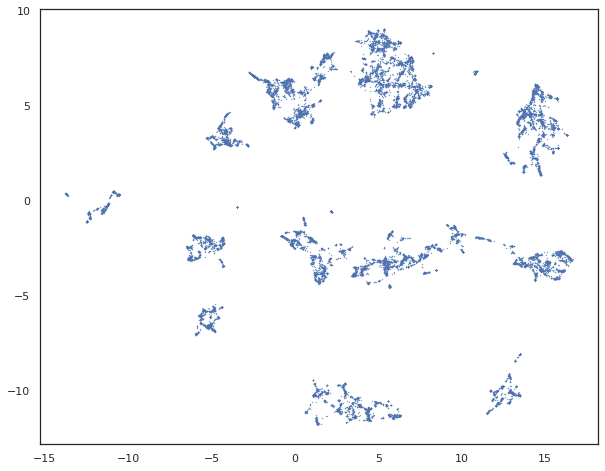

In [74]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1);

In [75]:
###Get cluster labels for your dataset
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=500,
).fit_predict(clusterable_embedding)

In [76]:
##See how many clusters 
set(labels)

#NB - -1 is a cluster of "noise" for HDBSCAN and should not be viewed as an actual cluster

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


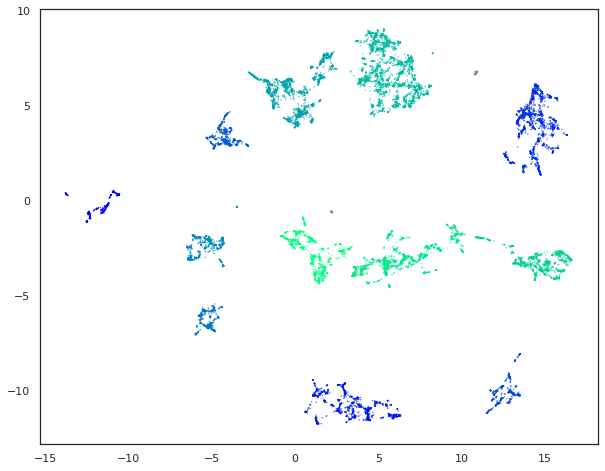

In [77]:
clustered = (labels >= 0)  ###  the -1 cluster is noise within HDBSCAN
plt.scatter(clusterable_embedding[~clustered, 0],
            clusterable_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clusterable_embedding[clustered, 0],
            clusterable_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='winter');